# Backpropagation tutorial

Following https://www.youtube.com/watch?v=VMj-3S1tku0&t=3049s tutorial
* backpropagation algorithm and neural net lib (pytorch-like)
* build MLP
* training loop with a simple data set

In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
class Value:
  
  # _children -> which nodes created this
  # _op -> which operation created this
  def __init__(self, data, _children=(), _op='', label=''): 
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None # how to evaluate derivative on this node
    self._prev = set(_children) # use set for optimization
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self):
    
    #builds the order in which we have to call ._backward() so we have already calculated all dependencies
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0 # base case, we think self as the root of the graph or the output of the function
    for node in reversed(topo):
      node._backward()

"""
L = d * f
L = (e + c) * f
L = ((a * b) + c) * f
"""
  
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

t = tanh(x)
dt/dx = 1 - tan(x)^2 = 1 - t^2

x -> (tanh) -> t
x.grad = dL/dx = dL/dt * dt/xd
x.grad = t.grad * (1-tan(x)^2) = t.grad * (1 - t^2)

In [36]:
# blackbox: draw_dot(root) graphs the tree with root the given node

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



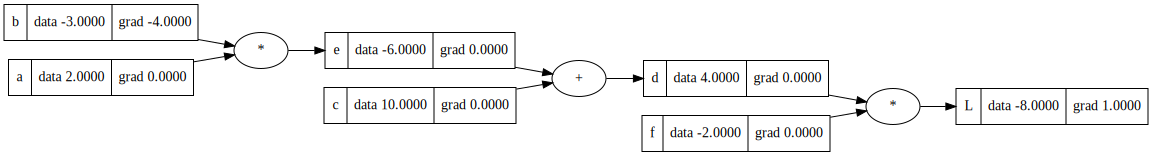

In [37]:
draw_dot(L)

In [31]:
"""
L = d * f
L = (e + c) * f
L = ((a * b) + c) * f

This is coded in the graph
"""

# L - L+h = h; h/h = 1. dL/dL = 1 (our 'base case')
# dL/dd = f
# dL/df = d

# dL/dc = f (from L definition)
# dL/dc = f; dL/cd = dL/dd * dd/dc (chain rule)

"""
dL/dc = dL/dd * dd/dc

dd/dc?
d = e + c
e + c+h - e + c = h; h/h = 1;

dL/dc = dL/dd * 1 = dL/dd; dL/dd already known
+ node doesn't change de gradient

---

dL/db = dL/de * de/db = a * dL/de = 2*(-2)
        ^knwon
e = a * b; de/db = a
* node multipies gradient for other prev nodes
        
"""

In [34]:
def lol(): # don't mess with the scope
  
  # check gradient for b is correct
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-3.9999999999995595


In [40]:
# so knowing this how we can make L go up
b.grad = -4.
# go in the direction of the gradient
b.data += b.grad * 0.1

e = a * b
d = e + c
L = d * f

print(L.data)

-6.4


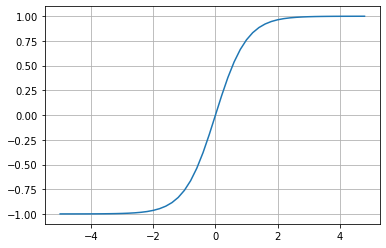

In [41]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [48]:
# neuron model

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

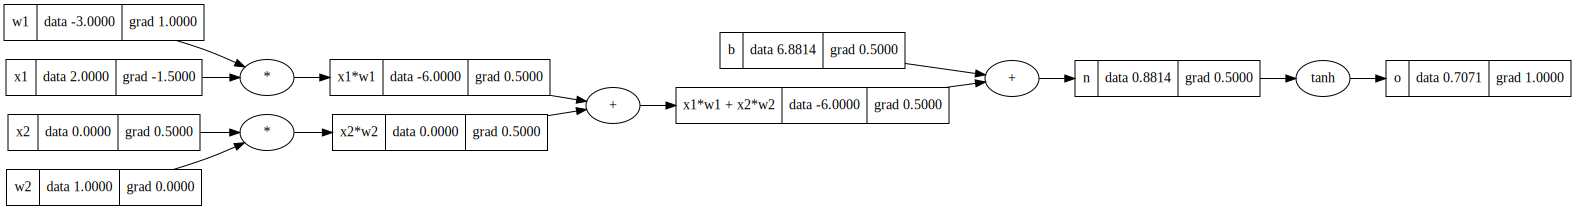

In [67]:
draw_dot(o)

In [50]:
o.grad = 1 # (base case)

In [53]:
o._backward()

In [55]:
n._backward()

In [61]:
b._backward() # leaf nodes are called with None function

In [62]:
x1w1x2w2._backward()

In [64]:
x1w1._backward()
x2w2._backward()

In [66]:
# this returns the order in which we have to call ._backward() so we have already calculated all dependencies
# it's just the topological sort of the graph we've built
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [69]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

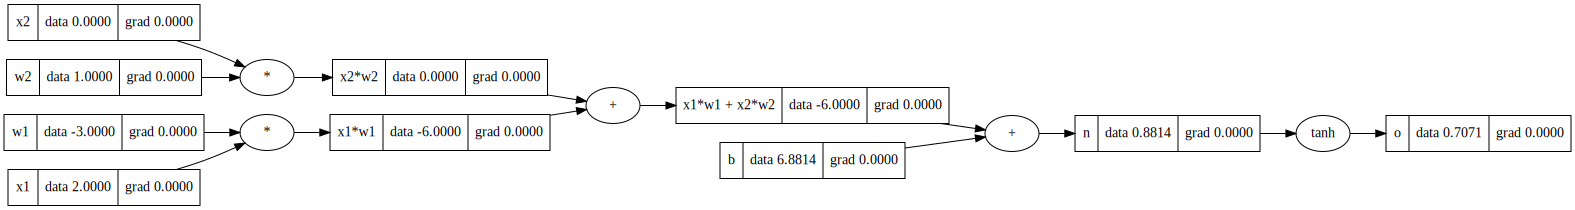

In [70]:
draw_dot(o)

In [71]:
o.backward()

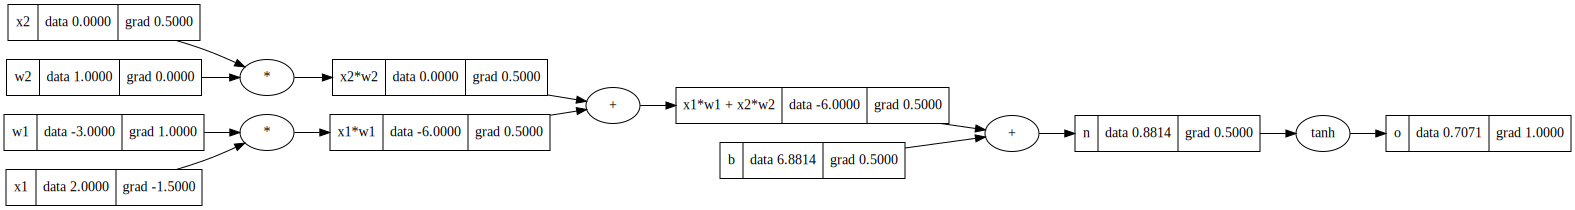

In [72]:
draw_dot(o)

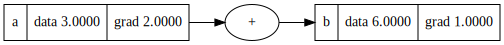

In [73]:
# solved buggy case: same node used more than once
# = to += so we don't overwrite

a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

Adding exp:
x -> (exp) -> o = e^x
de^x/dx = e^x
dL/dx = dL/do * do/dx
self.grad = out.grad * out.data


Adding pow:
x,k -> (pow) -> out = x^k
x^k/dx
(x^k)' = k * x^(k-1)
self.grad = out.grad * other * self.data ** (other -1)

In [75]:
# Now using pytorch
import torch

In [76]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [84]:
# same as above but more operations + operations with floats
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [87]:
import random

# building a basic neural net library

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [100]:
# Multi Layer Perceptron
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8662637170907048)

In [90]:
draw_dot(n(x));

In [102]:
# binary classifier neural net

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.8662637170907048),
 Value(data=0.9711554758660972),
 Value(data=0.9688705091286068),
 Value(data=0.8922895354977333)]

In [109]:
# tune weight so we get the output we want

# loss (a number) that measures performance of the neural net (how well we're predicting)
# high loss -> we're doing bad, it's just an optimization problem

# we'll use MSE loss
loss = sum((yout - ygt) ** 2 for yout, ygt in zip(ypred, ys))
loss

Value(data=7.791391929282928)

In [115]:
draw_dot(loss); # huge lol

In [116]:
loss.backward()

In [126]:
w = n.layers[0].neurons[0].w[0]
w.grad, w.data

(0.27241305288435874, 0.16625330203531852)

In [124]:
len(n.parameters()), n.parameters()[0]# these are the parameters we can change (xs are fixed) to optimzie loss

(41, Value(data=0.16625330203531852))

In [127]:
# optimization
# gradient descent time (training loop)

for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 7.791391929282928
1 7.658219061194645
2 7.294469467403975
3 5.639244516217144
4 0.3185439283124614
5 0.09884773948524925
6 0.06642272009875307
7 0.05066308220543606
8 0.04114112451940318
9 0.034707812448043746
10 0.030048460419885768
11 0.026508656132054127
12 0.023723442230473395
13 0.021472250345482956
14 0.01961350593924236
15 0.018051973425742218
16 0.016721130105716967
17 0.015573048937433278
18 0.014572294104120885
19 0.013692082072405503


In [128]:
ypred

[Value(data=0.9593635373587387),
 Value(data=-0.9509534926248903),
 Value(data=-0.9186787400329732),
 Value(data=0.9450267995466024)]